# Librerias

In [13]:
import fastai.collab as fc
import fastai.tabular.all as ft
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!ls

archive  data  faces  images  models  mydata  recommendation_system.ipynb


In [5]:
animes = pd.read_csv('/notebooks/storage/mydata/animes.csv')
animes.T.head(2)

,0,1,2,3,4,5,6,7,8,9,...,19301,19302,19303,19304,19305,19306,19307,19308,19309,19310
uid,28891,23273,34599,5114,31758,37510,199,38000,35247,2904,...,10350,1699,1293,150,4177,32979,123,1281,450,87
title,Haikyuu!! Second Season,Shigatsu wa Kimi no Uso,Made in Abyss,Fullmetal Alchemist: Brotherhood,Kizumonogatari III: Reiketsu-hen,Mob Psycho 100 II,Sen to Chihiro no Kamikakushi,Kimetsu no Yaiba,Owarimonogatari 2nd Season,Code Geass: Hangyaku no Lelouch R2,...,Hakuouki Sekkaroku,Romeo x Juliet,Urusei Yatsura,Blood+,Bounen no Xamdou,Flip Flappers,Fushigi Yuugi,Gakkou no Kaidan,InuYasha Movie 2: Kagami no Naka no Mugenjo,Mobile Suit Gundam: Char's Counterattack


In [7]:
users = pd.read_csv('/notebooks/storage/mydata/profiles.csv')
users.T.head(2)

,0,1,2,3,4,5,6,7,8,9,...,81717,81718,81719,81720,81721,81722,81723,81724,81725,81726
profile,DesolatePsyche,baekbeans,skrn,edgewalker00,aManOfCulture99,eneri,Waffle_Empress,NIGGER_BONER,jchang,shadowsplat,...,suzumehime,HajisSoul,samdineen20,bri_bri101,anjel,lovelessxd,Shattered_Angel,FluffyWalrus,camco,nyja-chan
gender,Male,Female,NaN,Male,Male,NaN,NaN,Male,Male,NaN,...,Female,Male,Female,Female,Female,Female,Female,Male,Female,Female


In [9]:
ratings = pd.read_csv('/notebooks/storage/mydata/reviews.csv', low_memory = True)
ratings.T.head(2)

,0,1,2,3,4,5,6,7,8,9,...,192102,192103,192104,192105,192106,192107,192108,192109,192110,192111
uid,255938,259117,253664,8254,291149,10046,247454,140903,23791,25115,...,223847,224292,181811,129039,279416,240067,285777,286904,287903,299323
profile,DesolatePsyche,baekbeans,skrn,edgewalker00,aManOfCulture99,eneri,Waffle_Empress,NIGGER_BONER,jchang,shadowsplat,...,Emil5634,BlazingWaters,Fear_the_Reefer,appleshampoo,Lordapollo,Unicorn819,ShizzoSVH,AlluMan96,AgentK300,Scarlet012


In [10]:
animes.columns

Index(['uid', 'title', 'synopsis', 'genre', 'aired', 'episodes', 'members',
       'popularity', 'ranked', 'score', 'img_url', 'link'],
      dtype='object')

In [11]:
users.columns

Index(['profile', 'gender', 'birthday', 'favorites_anime', 'link'], dtype='object')

# Primer intento: SOLO usando los ratings de los usuarios

In [12]:
ratings.columns

Index(['uid', 'profile', 'anime_uid', 'text', 'score', 'scores', 'link'], dtype='object')

In [22]:
ratings = ratings[['uid', 'anime_uid', 'score']]

In [23]:
ratings.head()

,uid,anime_uid,score
0,255938,34096,8
1,259117,34599,10
2,253664,28891,7
3,8254,2904,9
4,291149,4181,10


In [24]:
dls = fc.CollabDataLoaders.from_df(ratings, user_name = 'uid', item_name = 'anime_uid', rating_name = 'score', bs=128)

In [25]:
def flat_l1(yp, y): 
    return F.l1_loss(yp.view(-1), y.view(-1))

In [26]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, metrics=flat_l1)

In [27]:
learn.model
# u_weight: vector de usuarios
# i_weight: vector de animes 
# el número 50 en el vector viene del mismo colla_learner (lo puedes modificar)

EmbeddingDotBias(
  (u_weight): Embedding(114153, 50)
  (i_weight): Embedding(7722, 50)
  (u_bias): Embedding(114153, 1)
  (i_bias): Embedding(7722, 1)
)

In [29]:
learn.summary()

EmbeddingDotBias (Input shape: ['128 x 2'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            128 x 50             5,707,650  True      
________________________________________________________________
Embedding            128 x 50             386,100    True      
________________________________________________________________
Embedding            128 x 1              114,153    True      
________________________________________________________________
Embedding            128 x 1              7,722      True      
________________________________________________________________

Total params: 6,215,625
Total trainable params: 6,215,625
Total non-trainable params: 0

Optimizer used: <function ranger at 0x7f4746582e50>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

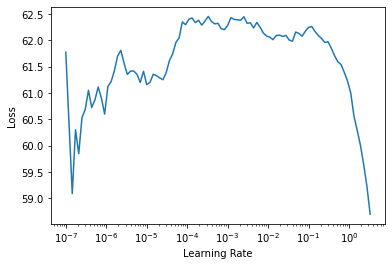

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,16.992338,16.166050,3.183861,00:12
1,7.017893,11.902308,2.608928,00:12
2,3.316580,11.402295,2.560741,00:12
3,2.910199,10.656550,2.442939,00:12
4,2.677184,10.136228,2.341321,00:12
5,2.483772,9.940720,2.297748,00:12
6,2.334622,9.768309,2.278651,00:12
7,2.291236,9.652760,2.251185,00:12
8,2.265074,9.578252,2.238924,00:12
9,2.326563,9.533548,2.231110,00:12


Básicamente nuestro modelo hasta ahora se equivoca en promedio un 1.8, tipo, tú ibas a dar la calificación de 5 y el modelo predice un 6.8.

# Mejorando el modelo

In [32]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, n_factors = 32, metrics=flat_l1)

In [33]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,17.047792,16.205851,3.195513,00:10
1,7.113659,11.320663,2.525270,00:10
2,3.304504,10.898797,2.493097,00:10
3,2.604981,10.203039,2.382646,00:10
4,2.343957,9.695484,2.279660,00:10
5,2.110753,9.484293,2.231323,00:10
6,1.947385,9.327130,2.209932,00:10
7,1.979636,9.228442,2.190621,00:10
8,1.826484,9.093459,2.163163,00:10
9,1.861269,9.096714,2.162258,00:10


In [34]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, n_factors = 4, metrics=flat_l1)

In [35]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,19.086966,18.143942,3.515608,00:09
1,8.347507,10.572177,2.427779,00:09
2,4.754016,8.727262,2.157624,00:09
3,2.990532,7.989791,2.051735,00:09
4,2.146818,7.603972,1.991534,00:09
5,1.834746,7.321267,1.909319,00:09
6,1.587840,7.202202,1.907813,00:09
7,1.500084,7.091961,1.869445,00:09
8,1.336291,7.029622,1.862495,00:09
9,1.266957,6.963642,1.845093,00:09


**Ahora usamos una red neuronal y embeddings para predecir los scores**

In [36]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, use_nn = True, emb_szs = {'uid': 16, 'anime_uid': 16}, metrics=flat_l1)
# aquí, el embedding del anime y del usuario no tiene que ser del mismo tamaño necesariamente

In [37]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(114153, 16)
    (1): Embedding(7722, 16)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=32, out_features=50, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [38]:
learn.summary()

EmbeddingNN (Input shape: ['128 x 2'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            128 x 16             1,826,448  True      
________________________________________________________________
Embedding            128 x 16             123,552    True      
________________________________________________________________
Dropout              128 x 32             0          False     
________________________________________________________________
BatchNorm1d          128 x 32             64         True      
________________________________________________________________
Linear               128 x 50             1,600      True      
________________________________________________________________
ReLU                 128 x 50             0          False     
________________________________________________________________
Linear               128 x 1              51         True      
___________________________________________________________

In [39]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,3.370636,3.247148,1.396185,00:11
1,1.418539,2.784734,1.209292,00:11
2,0.919571,2.630530,1.152667,00:12
3,0.772118,2.584629,1.134441,00:12
4,0.583331,2.546520,1.104645,00:13
5,0.517081,2.527133,1.099811,00:15
6,0.482318,2.533254,1.090999,00:12
7,0.470444,2.512447,1.075809,00:14
8,0.445987,2.531115,1.067248,00:12
9,0.474148,2.517100,1.054031,00:12


In [40]:
learn = fc.collab_learner(dls, opt_func = fc.ranger, use_nn = True, emb_szs = {'uid': 32, 'anime_uid': 32}, layers = [1024, 512], metrics=flat_l1)
# hacemos el modelo más profundo

In [41]:
learn.fit_one_cycle(20, 3e-2, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,flat_l1,time
0,3.310527,3.305095,1.372719,00:13
1,1.670862,2.754833,1.172801,00:12
2,0.867559,2.696796,1.114985,00:12
3,0.672564,2.674608,1.122099,00:12
4,0.556546,2.690375,1.075964,00:12
5,0.519311,2.973881,1.169870,00:12
6,0.560468,3.119360,1.176510,00:12
7,0.618673,2.871677,1.145784,00:12
8,0.592854,3.263130,1.101028,00:12
9,0.583192,5.222058,1.146698,00:12
